In [155]:
import cobra
import cobra.test
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

In [117]:
%load_ext autoreload
import sys
if not '/Users/nlarusstone/Documents/MPhil/Research/cf_fba' in sys.path:
    sys.path.append('/Users/nlarusstone/Documents/MPhil/Research/cf_fba')
import src.utils as utils
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [255]:
#model = cobra.io.load_json_model(filename='../models/ecoli_but.json')
model = cobra.io.read_sbml_model('../models/ecoli_cf_base.sbml')
#model = cobra.io.read_sbml_model('../models/iJO1366.xml')
mod_cf = model.copy()

In [119]:
df = pd.read_csv('../data/Karim_MetEng_2018_Figure2_Data.csv')
df.drop(columns=['Area_1', 'Area_2', 'Conc_1', 'Conc_2'], inplace=True)
df.head()

,AVG,STD,AVG.1,STD.1,Mg(Glu)2,NH4(Glu),K(Glu),Glucose,K2HPO4,NAD,ATP,CoA
0,0.00,0.0,0.00,0.00,8.0,10.0,134,0,10,0.5,0.0,0.5
1,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.0,0.0,0.5
2,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,2.0
3,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,1.6
4,1.21,1.7,0.09,0.13,8.0,10.0,134,200,10,0.5,2.0,0.5


In [144]:
# TODO: Look into GoalEnv
class FBA_Env(gym.Env):      
    def __init__(self, model, df):
        self.model = model.copy()
        self.cur_model = self.model.copy()
        self.rxns = model.reactions
        self.n_rxns = len(self.rxns)
        # TODO Add metabs
        self.metabs = model.metabolites
        n_metabs = len(self.metabs)
        # LEARNING FROM EXPERIMENTAL DATA:
        self.df = df
        self.cond_scores = df['AVG.1']
        # Add 1 for not removing any
        self.action_space = spaces.Discrete(self.n_rxns) # TODO: Think about using MultiBinary
        self.action_types = ('remove', 'add')
        #spaces.Dict({"reaction": spaces.Discrete(n_rxns + 1), "metabolite": spaces.Discrete(n_metabs + 1)})
        # Whether or not a reaction is present
        self.observation_space = spaces.MultiBinary(self.n_rxns)
        # In case they forget to reset
        self.state = np.ones(self.n_rxns, dtype=np.int8)
        self.time = 0
        
        self.unique_fluxes = {}
        
        self.log = []
        
        self._seed()
        #spaces.Dict({"reaction": spaces.Discrete(2), "metabolite": spaces.Discrete(3)})
        
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _get_obs(self):
        return self.state
    
    def _take_action(self, state, action):
        # Returns new state
        return NotImplemented
    
    def _evaluate(self, state_rxns):
        return NotImplemented
    
    def reset(self):
        # TODO, choose random starting state
        self.state = np.ones(self.n_rxns, dtype=np.int8)
        self.cur_model = self.model.copy()
        self.last_action = None
        self.time = 0
        
        return self._get_obs()

    def step(self,action):
        # TODO: do better than this?
        new_state = self._take_action(self.state, action)
        self.state = new_state
        reward = self._evaluate(self.state)

        done = False
        #if self.time > 300:
        #    done = True

        self.time += 1
            
        return self.rxns[action[0]], reward, done, action

In [165]:
# TODO: Look into GoalEnv
class FBA_Step_Env(FBA_Env):  
    def _take_action(self, state, act):
        action, action_type = act
        if action_type == 'add':
            state[action] = 1
            rxn = self.rxns[action]
            self.cur_model.add_reaction(rxn)
        else:
        # Returns new state
            state[action] = 0
            rxn = self.rxns[action]
            if rxn in self.cur_model.reactions:
                self.cur_model.reactions.get_by_id(rxn.id).remove_from_model()
            else:
                self.log.append(('rxn {0} not in model with state {1}'.format(rxn, self.state)))
        return state
    
    def _evaluate(self, state_rxns):
        objs = utils.add_addl_reactants(self.cur_model, self.df)
        if not tuple(objs) in self.unique_fluxes:
            self.unique_fluxes[tuple(objs)] = state_rxns
        if sum(objs) < 0.01 or np.isnan(objs).any() or not objs:
            return -1000
        corr = scipy.stats.spearmanr(objs, self.cond_scores)
        return corr
    
    def _evaluate_fluxes(self, state_rxns):
        #objs = utils.add_addl_reactants(self.cur_model, self.df)
        objs, fluxes = utils.gen_fluxes_addl_reactants(self.cur_model, self.df)
        if not tuple(objs) in self.unique_fluxes:
            self.unique_fluxes[tuple(objs)] = (fluxes, state_rxns)
        if sum(objs) < 0.01:
            return -1000
        corr = scipy.stats.spearmanr(objs, self.cond_scores)
        return corr
    
    def _evaluate_flux(self, state_rxns):
        #objs = utils.add_addl_reactants(self.cur_model, self.df)
        obj, fluxes = utils.gen_fluxes(self.cur_model)
        if not tuple(fluxes) in self.unique_fluxes:
            self.unique_fluxes[tuple(fluxes)] = state_rxns
        if obj < 10 ** -7:
            return -1000
        return obj

In [166]:
class RandomAgent(object):
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done, prev_action):
        return (self.action_space.sample(), 'remove')

In [167]:
class AddBackAgent(object):
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done, prev_action):
        if reward < -1:
            return (prev_action[0], 'add')
        return (self.action_space.sample(), 'remove')

In [171]:
env = FBA_Step_Env(mod_cf, df)
agent = AddBackAgent(env.action_space)
max_reward = (0, None)
min_reward = (0, None)
prev_action, done = None, False
for i_episode in range(20):
    print 'Episode {0}'.format(i_episode)
    observation = env.reset()
    reward = 0
    for t in range(1001):
        #env.render()
        #print(observation)
        action = agent.act(observation, reward, done, prev_action)
        observation, reward, done, prev_action = env.step(action)
        if np.isnan(reward).any():
            print 'NAN'
            break
        if t % 10 == 0:
            print 'Time {0}, reward: {1}'.format(t, reward)
        if reward > max_reward[0]:
            max_reward = (reward, env.state)
        if reward < min_reward[0]:
            min_reward = (reward, env.state)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
print max_reward, min_reward

Episode 0
Time 0, reward: SpearmanrResult(correlation=-0.17550469962430487, pvalue=0.27239169559356013)
Time 10, reward: SpearmanrResult(correlation=-0.17550469962430487, pvalue=0.27239169559356013)
Time 20, reward: SpearmanrResult(correlation=-0.16572293526721518, pvalue=0.3004306847707215)
Time 30, reward: SpearmanrResult(correlation=-0.14084174978072547, pvalue=0.3797659804294531)
Time 40, reward: SpearmanrResult(correlation=-0.20987688294694867, pvalue=0.18782771364725595)
Time 50, reward: SpearmanrResult(correlation=-0.11898505817545255, pvalue=0.45872188085479504)
Time 60, reward: SpearmanrResult(correlation=-0.20987688294694867, pvalue=0.18782771364725595)
Time 70, reward: SpearmanrResult(correlation=-0.09438894300109013, pvalue=0.5571994263547196)
Time 80, reward: SpearmanrResult(correlation=-0.09438894300109013, pvalue=0.5571994263547196)
Time 90, reward: SpearmanrResult(correlation=-0.09438894300109013, pvalue=0.5571994263547196)
Time 100, reward: SpearmanrResult(correlation=

ValueError: The input must have at least 3 entries!

In [275]:
dis_rxns = []
obj_l = []
i = 0
for objs, rxns in env.unique_fluxes.items():
    i += 1
    if sum(objs) < 0.01:
        continue
    dis_rxns.append(rxns)
    obj_l.append(objs)
print i
print len(dis_rxns)

1544
1534


In [279]:
s = dis_rxns[0]

In [269]:
def state_to_flux(model, rxns, state, df):
    model.repair()
    # 1 represents a reaction to keep, so remove if not 1
    rxns_to_remove = [model.reactions.get_by_id(rxn.id) for rxn,valid in zip(rxns, state) if not valid]
    with model as mod:
        #rxns_to_remove = [mod.reactions.get_by_id(rxn.id).remove_from_model() for rxn,valid in zip(rxns, state) if not valid]
        print len(mod.reactions)
        mod.remove_reactions(reactions=rxns_to_remove)
        print len(mod.reactions)
        objs, fluxes = utils.gen_fluxes_addl_reactants(mod, df)
    return objs, fluxes
o, f = state_to_flux(env.model, env.rxns, s, env.df)

2635
2023


In [277]:
np.equal(o, obj_l[0])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [271]:
o

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [278]:
obj_l[0]

(-4.6247687528095537e-17,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.1092250922509227,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 1.3443935841371894e-15,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282,
 0.10922509225092282)

In [179]:
max_len = (0, None)
for rxn in range(len(dis_rxns)):
    for flux_ser in dis_rxns[rxn][0]:
        if flux_ser.shape[0] > max_len[0]:
            max_len = (flux_ser.shape[0], flux_ser)
ind = max_len[1].index

TypeError: 'numpy.int8' object is not iterable

In [ ]:
fluxes = []
for rxn in range(len(dis_rxns)):
    experiments = []
    for flux_ser in dis_rxns[rxn][0]:
        flux_ser_pad = flux_ser.reindex(ind)
        experiments.append(np.array(flux_ser_pad))
    experiment = np.stack(experiments, axis=0)
    fluxes.append(experiment)
flux_arr = np.stack(fluxes, axis=0)
flux_arr.shape

In [133]:
flux_arr[0][0].shape

(2586,)

In [154]:
np.save('../data/fluxes_ecoli_but', flux_arr)
np.save('../data/rxns_ecoli_but', env.rxns)

In [162]:
flux_arr_no_nan = np.nan_to_num(x=flux_arr)

In [163]:
#def viz_flux_std(flux_arr):
stds = []
for exp in flux_arr_no_nan:
    for cond in exp:
        stds.append(np.std(cond))
#viz_flux_std(flux_arr)

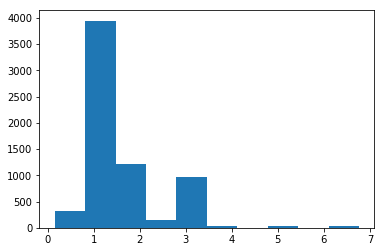

In [164]:
plt.hist(stds)
plt.show()

In [18]:
# TODO: Look into GoalEnv
class FBA_Pathway_Env(FBA_Env):  
    def _take_action(self, state, action):
        # Returns new state
        state[action] = 0
        rxn = self.rxns[action]
        self.cur_model.reactions.get_by_id(rxn.id).remove_from_model()
        return state
    
    def _evaluate(self, state_rxns):
        objs = utils.add_addl_reactants(self.cur_model, self.df)
        #for start_cond_dict in self.starting_conds:
        #    start_cond = start_cond_dict.keys()
            # Update Model with starting condition
       #     with self.cur_model as model:
        #        model.add_reactions(start_cond)
        #        objs.append(model.slim_optimize())
        # Discourage infeasible solutions
        if sum(objs) == 0:
            return -1000
        corr = scipy.stats.spearmanr(objs, self.cond_scores)
        return corr

In [176]:
def test(mod, starting_conds, cond_scores):
    model = mod.copy()
    objs = []
    for start_cond_dict in starting_conds:
        start_cond = start_cond_dict.keys()
        # Update Model with starting condition
        with model as model:
            model.add_reactions(start_cond)
            objs.append(model.slim_optimize())
    print objs
    corr = scipy.stats.spearmanr(objs, cond_scores)
    return corr
test(mod_cf, rxn_conds, results)

[0.015069444444443763, 0.015069444444444038, 0.015069444444443357, 0.015069444444443357, 0.015069444444444705, 0.015069444444443865, 0.028958333333332198, 0.015069444444443357, 0.015069444444443357, 0.015069444444443357, 0.015069444444443357, 0.015069444444443357, 0.015069444444444705, 0.015069444444443865, 0.02340277777777668, 0.015069444444443357, 0.015069444444443357, 0.015069444444444705, 0.015069444444443865, 0.015069444444444097, 0.015069444444443357, 0.015069444444443357, 0.01784722222222109, 0.015069444444443436, 0.015069444444443357, 0.015069444444443357, 0.015069444444443357, 0.015069444444444522, 0.015069444444443357, 0.015069444444444323, 0.015069444444443357, 0.015069444444443357, 0.015069444444443357, 0.015069444444443357, 0.015069444444443357, 0.0011805555555556254, 0.006736111111111482, 0.015069444444443357, 0.015069444444443357, 0.015069444444443357, 0.015069444444443357]


SpearmanrResult(correlation=-0.40796294739949274, pvalue=0.008102888644114212)

In [177]:
with mod_cf as model:
    model.reactions.HSDy.remove_from_model()
    model.reactions.UDPGPpp.remove_from_model()
    print test(model, rxn_conds, results)

[0.01506944444444309, 0.015069444444442822, 0.015069444444443436, 0.015069444444443343, 0.015069444444444005, 0.015069444444443011, 0.028958333333331886, 0.015069444444444935, 0.015069444444444935, 0.015069444444444935, 0.015069444444447501, 0.015069444444447501, 0.015069444444444724, 0.015069444444444935, 0.02340277777777719, 0.015069444444444935, 0.015069444444444935, 0.015069444444444724, 0.015069444444447501, 0.015069444444444855, 0.015069444444444935, 0.015069444444444935, 0.017847222222222698, 0.015069444444444238, 0.015069444444444935, 0.015069444444447501, 0.015069444444447501, 0.015069444444441535, 0.015069444444444935, 0.015069444444444885, 0.015069444444447501, 0.015069444444447501, 0.015069444444444935, 0.015069444444444935, 0.015069444444447501, 0.0011805555555562995, 0.006736111111113903, 0.015069444444447501, 0.015069444444444935, 0.015069444444444935, 0.015069444444444935]
SpearmanrResult(correlation=0.19192023893475982, pvalue=0.22932525346762614)


In [ ]:
import numpy.random as npr
import sys
import time
import matplotlib.pyplot as plt
import numpy as np

class Learner:

    def __init__(self, discount):
        self.last_state  = None
        self.last_action = None
        self.last_reward = None
        self.Q = {}
        self.alphas = {}
        self.epsilon = None # will be modified by loop
        self.score = 0
        self.discount = discount
        self.raw_states = []
        self.disc_states = []

    def reset(self):
        self.last_state  = None
        self.last_action = None
        self.last_reward = None
        self.score = 0

    def disc_state(self, old_state):
        old_bot_diff = old_state['tree']['bot'] - old_state['monkey']['bot']
        new_bot_diff = (old_bot_diff + 333) / 100
        new_bot_diff = max(0, new_bot_diff)
        
        old_tree_dist = old_state['tree']['dist']
        new_tree_dist = (old_tree_dist + 115) / 120
        new_tree_dist = max(0, new_tree_dist)

        old_monk_vel = old_state['monkey']['vel']
        new_monk_vel = (old_monk_vel + 40) / 20
        new_monk_vel = max(0, new_monk_vel)

        return (new_bot_diff, new_tree_dist, new_monk_vel)
        
        
    def action_callback(self, state):
        '''Implement this function to learn things and take actions.
        Return 0 if you don't want to jump and 1 if you do.'''
        
        self.raw_states.append(state)
        self.disc_states.append(self.disc_state(state))

        if self.last_state is None:
            self.last_state = state
            self.last_action = 0
            return 0

        # self.states.append(state)
        discount = self.discount

        # UPDATE Q
        last_state = self.disc_state(self.last_state)
        cur_state = self.disc_state(state)
        last_action = self.last_action
        last_reward = self.last_reward
        
        if last_state not in self.Q:
            self.Q[last_state] = [0., 0.]
            self.alphas[last_state] = [1., 1.]
        if cur_state not in self.Q:
            self.Q[cur_state] = [0., 0.]
            self.alphas[cur_state] = [1., 1.]

        old_val = self.Q[last_state][last_action]
        alpha = self.alphas[last_state][last_action]
        self.Q[last_state][last_action] = old_val + (1./alpha)*(last_reward + discount*max(self.Q[cur_state]) - old_val)
        self.alphas[last_state][last_action] += 1.
        
        # CHOOSE NEW ACTION
        rnd = npr.random()

        if rnd > self.epsilon:
            # choose optimal action
            action_vals = self.Q[cur_state]
            new_action = 0 if action_vals[0] >= action_vals[1] else 1
        else:
            # act randomly, 0.7 prob of holding, 0.3 prob of jumping
            rnd  = npr.random()
            new_action = 0 if rnd < 0.8 else 1

        self.last_action = new_action
        self.last_state  = state
        self.score = state['score']

        return self.last_action

    def reward_callback(self, reward):
        '''This gets called so you can see what reward you get.'''
        self.last_reward = reward


if len(sys.argv) != 3:
    print 'Usage: python QLearn.py numIters discountRate'
    sys.exit(0)

iters = int(sys.argv[1])
discount = float(sys.argv[2])
learner = Learner(discount)
scores = []

for ii in xrange(iters):

    learner.epsilon = 1./(ii+1)

    # Make a new monkey object.
    swing = SwingyMonkey(sound=False,            # Don't play sounds.
                         text="Epoch %d" % (ii), # Display the epoch on screen.
                         tick_length=1,          # Make game ticks super fast.
                         action_callback=learner.action_callback,
                         reward_callback=learner.reward_callback)
    # Loop until you hit something.
    while swing.game_loop():
        pass
    
    scores.append(learner.score)

    # Reset the state of the learner.
    learner.reset()

def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(scores)
plt.show()
plt.plot(moving_average(scores))
plt.show()
plt.hist(scores)
plt.show()
print np.median(scores)
print np.mean(scores)
print max(scores)

In [ ]:
# TODO: Look into GoalEnv
class FBA_Env(gym.Env):      
    def __init__(self, model):
        self.model = model
        self.rxns = model.reactions
        self.n_rxns = len(self.rxns)
        # TODO Add metabs
        self.metabs = model.metabolites
        n_metabs = len(self.metabs)
        # Add 1 for not removing any
        self.action_space = spaces.Discrete(n_rxns + 1) # TODO: Think about using MultiBinary
        #spaces.Dict({"reaction": spaces.Discrete(n_rxns + 1), "metabolite": spaces.Discrete(n_metabs + 1)})
        # Whether or not a reaction is present
        self.observation_space = spaces.MultiBinary(n_rxns + 1)
        self.state = self.observation_space.sample()
        self.time = 0
        
        self._seed()
        #spaces.Dict({"reaction": spaces.Discrete(2), "metabolite": spaces.Discrete(3)})

    def _evaluate(self, state_rxns):
        # 1 represents a reaction to keep, so remove if not 1
        rxns_to_remove = [i for i,j in zip(self.rxns, state_rxns) if not j]
        with self.model as model:
            model.remove_reactions(rxns_to_remove)
            obj = model.slim_optimize()
        return obj
        
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def step(self,action):
        cur_rxns = self.state        
        x = self.state
        reward = self._evaluate(cur_rxns)
        # TODO: do better than this?
        new_rxns = self.observation_space.sample()
        new_x = new_rxns

        self.state = new_x

        done = False
        if self.time > 300:
            done = True

        self.time += 1
            
        return self._get_obs(), reward, done, {}

    def reset(self):
        # self.step(np.array([0,0,0,0]))[0]
        # TODO, choose random starting state
        self.state = np.ones(self.n_rxns, dtype=np.int8)
        self.last_u = None
        self.time = 0
        
        return self._get_obs()

    def _get_obs(self):
        return self.state

    #def get_params(self):
    #    return self.A, self.B, self.Q, self.R

In [110]:
df.head()

,AVG,STD,AVG.1,STD.1,Mg(Glu)2,NH4(Glu),K(Glu),Glucose,K2HPO4,NAD,ATP,CoA
0,0.00,0.0,0.00,0.00,8.0,10.0,134,0,10,0.5,0.0,0.5
1,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.0,0.0,0.5
2,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,2.0
3,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,1.6
4,1.21,1.7,0.09,0.13,8.0,10.0,134,200,10,0.5,2.0,0.5
